In [1]:
import os
import sys

sys.path.insert(1, os.path.join(sys.path[0], '..'))

from src import viz

import numpy as np
import scipy.linalg as lalg

In [2]:
def theta(h, theta_r, theta_s, n, m, alpha) :
    """Calculates volumetric soil moisture

    Args:
        h (float) : water pressure head
        theta_r (float) : residual soil moisture
        theta_s (float) : saturated soil moisture
        n (float) : van Genuchten model parameter
        m (float) : van Genuchten model parameter
        alpha (float) : van Genuchten model parameter
    
    Returns:
        theta (float) : volumetric soil moisture
    """
    if h >= 0 :
        return theta_s

    return theta_r + (theta_s - theta_r) * ((1 + np.abs(alpha * h)**n)**(-m))

def S(theta, theta_r, theta_s) :
    """Calculates relative saturation

    Args:
        theta (float) : volumetric soil moisture
        theta_r (float) : residual soil moisture
        theta_s (float) : saturated soil moisture

    Returns:
        S (float) : relative saturation
    """
    return (theta - theta_r) / (theta_s - theta_r)

def h_(theta, theta_r, theta_s, n, m, alpha) :
    """Calculates water pressure head

    Args:
        theta (float) : volumetric soil moisture
        theta_r (float) : residual soil moisture
        theta_s (float) : saturated soil moisture
        n (float) : van Genuchten model parameter
        m (float) : van Genuchten model parameter
        alpha (float) : van Genuchten model parameter
    
    Returns:
        h (float) : water pressure head
    """
    s = S(theta, theta_r, theta_s)
    return -((s**(-1 / m) - 1)**(1 / n)) / alpha

def k(h, S, k_s, m) :
    """Calculates hydraulic conductivity

    Args:
        h (float) : water pressure head
        S (float) : relative saturation
        k_s (float) : saturated hydraulic conductivity
        m (float) : van Genuchten model parameter
    
    Returns:
        K (float) : hydraulic conductivity
    """
    if h >= 0 :
        return k_s

    return k_s * np.sqrt(S) * ((1 - (1 - S**(1/m))**m)**2)

def C_(h, theta_r, theta_s, n, m, alpha) :
    """Calculates water capacity (dtheta/dh)

    Args:
        h (float) : water pressure head
        theta_r (float) : residual soil moisture
        theta_s (float) : saturated soil moisture
        n (float) : van Genuchten model parameter
        m (float) : van Genuchten model parameter
        alpha (float) : van Genuchten model parameter

    Returns:
        C (float) : water capacity
    """
    if h >= 0 :
        return 10**(-20)
    
    return 10**(-20) + ((theta_s - theta_r) * m * n * alpha * (np.abs(alpha * h)**(n - 1))) / ((1 + np.abs(alpha * h)**n)**(m + 1))


In [3]:
# Setting constants

theta_r = 0.075
theta_s = 0.287
k_s = 1.5
alpha = 0.05
n = 2
m = 1 - 1 / n

param = [theta_r, theta_s, k_s, alpha, n, m]

h_t0 = -65
h_z0 = -65
h_z60 = -20.7

dz = 1
dt = 1

In [4]:
def picard_solver(z_max, t_max, dz=dz, dt=dt, h_t0=h_t0, downbound="dirichlet", h_z0=h_z0, J_z0=0, topbound="dirichlet", h_z_max=h_z60, timevar=(lambda x : 0), J_z_max=0, param=param, n_iter=10) :
    """Solves the Richards equation using the modified Picard method for mass conservation

    Args:
        z_max (float) : maximum z value to consider. Must be positive.
        t_max (float) : maximum t value to consider. Must be positive.
        dz (float, optional) : z step, ideally a divider of z_max.
        dt (float, optional) : t step, ideally a divider of t_max.
        h_t0 (float, optional) : value of h(z, t=0)
        downbound (string, optional) : type of boundary condition for z=0. Either "dirichlet", "flux" or "free_drainage".
        h_z0 (float, optional) : value of h(z=0, t) if a Dirichlet boundary condition is set
        J_z0 (float, optional) : value of J(z=0, t) if a flux (Neumann) boundary condition is set
        topbound (string, optional) : type of boundary condition for z=z_max. Either "dirichlet", "flux" or "free_drainage".
        h_z_max (float, optional) : value of h(z=z_max, t) if a Dirichlet boundary condition is set
        timevar (function, optional) : time variation of h(z=z_max, t) to add to h_z_max if a Dirichlet boundary condition is set
        J_z_max (float, optional) : value of J(z=z_max, t) if a flux (Neumann) boundary condition is set
        param (array-like, optional) : hydrological hyperparameters of the Richards equation
        n_iter (int, optional) : number of Picard iterations to run

    Returns:
        z (1D ndarray) : mesh defined by z_max and dz
        t (1D ndarray) : mesh defined by t_max and dt
        h (2D ndarray) : h values taken by the solution over z and t
        thta (2D ndarray) : theta values taken by the solution over z and t

    """
    
    theta_r, theta_s, k_s, alpha, n, m = param

    Svec = np.vectorize(S)
    kvec = np.vectorize(k)
    thvec = np.vectorize(theta)
    Cvec = np.vectorize(C_)

    z = np.arange(0, z_max + dz, dz)
    n_z = len(z)
    t = np.arange(0, t_max + dt, dt)
    n_t = len(t)

    # Initialization :
    h = np.empty((n_z, n_t))
    # Initial condition t = 0 :
    h[:, 0] = np.full(n_z, h_t0)
    # Boundary conditions :
    if downbound == "dirichlet" :
        h[0] = np.full(n_t, h_z0)
    if topbound == "dirichlet" :
        h[n_z - 1] = np.full(n_t, h_z_max)

    # Time iteration
    for i in range(1, n_t) :
        # Initializing h and theta as their final values during the previous time iteration
        h0 = h[:, i - 1]
        thta0 = thvec(h0, theta_r, theta_s, n, m, alpha)

        h[:, i] = np.copy(h0)
        h[n_z - 1, i] = h_z_max + timevar(t[i])

        # Picard iteration
        for j in range(n_iter) :
            hm = h[:, i]
            thtam = thvec(hm, theta_r, theta_s, n, m, alpha)
            hdiff = np.convolve(hm, [1, -1], mode='valid')

            s = Svec(thtam, theta_r, theta_s)
            K = kvec(hm, s, k_s, m)

            K05 = np.convolve(K, [1/2, 1/2], mode='valid')
            Kplus05 = K05[1:]
            Kminus05 = K05[:(n_z - 2)]

            c = Cvec(hm, theta_r, theta_s, n, m, alpha)

            # Computing interior tridiagonal matrix coefficients
            A = -Kminus05 / (dz**2)
            B = c[1:(n_z - 1)] / dt + (Kplus05 + Kminus05) / (dz**2)
            C = -Kplus05 / (dz**2)
            D = (Kplus05 * hdiff[1:] - Kminus05 * hdiff[:(n_z - 2)]) / (dz**2) + (Kplus05 - Kminus05) / dz - (thtam - thta0)[1:(n_z - 1)] / dt

            # Setting boundary coefficients
            if downbound == "dirichlet" :
                B0 = 1
                C0 = 0
                D0 = 0
            
            elif downbound == "free_drainage" :
                B0 = c[0] / dt + 2 * K[0] / (dz**2)
                C0 = -2 * K[0] / (dz**2)
                D0 = 2 * K[0] * hdiff[0] / (dz**2) + (K05[0] - K[0]) / dz - (thtam - thta0)[0] / dt
            
            elif downbound == "flux" :
                B0 = c[0] / dt + 2 * K[0] / (dz**2)
                C0 = -2 * K[0] / (dz**2)
                D0 = 2 * K[0] * hdiff[0] / (dz**2) - (J_z0 / K[0] - 2) * (K05[0] - J_z0) / dz - 2 * (K[0] - J_z0) / dz - (thtam - thta0)[0] / dt

            if topbound == "dirichlet" :
                Anz = 0
                Bnz = 1
                Dnz = 0
            
            elif topbound == "free_drainage" :
                Anz = -2 * K[n_z - 1] / (dz**2)
                Bnz = c[n_z - 1] / dt + 2 * K[n_z - 1] / (dz**2)
                Dnz = -2 * K[n_z - 1] * hdiff[n_z - 2] / (dz**2) + (K[n_z - 1] - K05[n_z - 2]) / dz - (thtam - thta0)[n_z - 1] / dt
            
            elif topbound == "flux" :
                Anz = -2 * K[n_z - 1] / (dz**2)
                Bnz = c[n_z - 1] / dt + 2 * K[n_z - 1] / (dz**2)
                Dnz = -2 * K[n_z - 1] * hdiff[n_z - 2] / (dz**2) - (J_z_max / K[n_z - 1] - 2) * (J_z_max - K05[n_z - 2]) / dz + 2 * (K[n_z - 1] - J_z_max) / dz - (thtam - thta0)[n_z - 1] / dt

            A = np.concatenate((A, [Anz]))
            B = np.concatenate(([B0], B, [Bnz]))
            C = np.concatenate(([C0], C))
            D = np.concatenate(([D0], D, [Dnz]))

            # Solving tridiagonal system
            M = np.diag(A, -1) + np.diag(B) + np.diag(C, 1)
            lu, piv = lalg.lu_factor(M)
            delta = lalg.lu_solve((lu, piv), D)
            
            # Updating h
            h[:, i] += delta

    thta = thvec(h, theta_r, theta_s, n, m, alpha)

    return z, t, h, thta

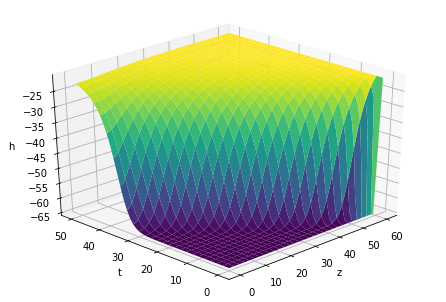

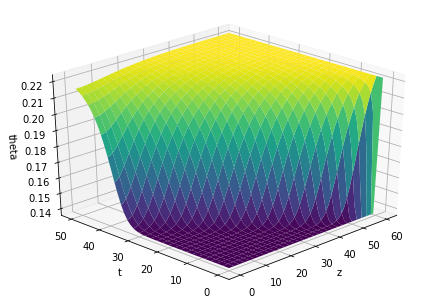

In [7]:
z, t, h, thta = picard_solver(z_max=60, t_max=50, downbound="free_drainage")

viz.plot_3d(z, t, h, xlabel="z", ylabel="t", zlabel="h")
viz.plot_3d(z, t, thta, xlabel="z", ylabel="t", zlabel="theta")